<a href="https://colab.research.google.com/github/antonivin/Object_Detection_PyTorch/blob/main/Kangaroo_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/antonivin/Object_Detection_PyTorch.git

fatal: destination path 'Object_Detection_PyTorch' already exists and is not an empty directory.


In [2]:
!git clone https://github.com/pytorch/vision.git

fatal: destination path 'vision' already exists and is not an empty directory.


In [3]:
!cp /content/vision/references/detection/transforms.py /content
!cp /content/vision/references/detection/utils.py /content

In [4]:
import torch
import os
import torchvision
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
from pylab import *

import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

import glob
import os

image_size = (224,224)

In [5]:
class kangaroo(Dataset):
    
    def __init__(self, path, transform):
        image_dir = path + '/Object_Detection_PyTorch/kangaroo/images/' 
        annotation_dir = path + '/Object_Detection_PyTorch/kangaroo/pascal/'
        self.transform = transform 
        self.image_names = os.listdir(image_dir)
        self.image_names.sort()
        self.image_names = [os.path.join(image_dir,image_name) for image_name in self.image_names]
        self.annotation_names = os.listdir(annotation_dir)
        self.annotation_names.sort()
        self.annotation_names = [os.path.join(annotation_dir,annotation_name) for annotation_name in self.annotation_names]
     
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img = Image.open(image_name)
        w,h = img.size
        img = img.resize(image_size)
        annotation_name = self.annotation_names[idx]
        annotation_tree = ET.parse(annotation_name, ET.XMLParser(encoding='utf-8'))
        classes = annotation_tree.find("object").find("name").text 
        num_objs = 1
        boxes = []
        bndbox_xml = annotation_tree.find("object").find("bndbox")
        xmin = int(bndbox_xml.find('xmin').text)
        ymin = int(bndbox_xml.find('ymin').text)
        xmax = int(bndbox_xml.find('xmax').text)
        ymax = int(bndbox_xml.find('ymax').text)
        boxes.append([xmin*224/w,ymin*224/h,xmax*224/w,ymax*224/h])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        if self.transform is not None:
            img, target = self.transform(img, target)
        #img /=255
        return img, target
    
    def __len__(self):
        return len(self.image_names)

def collate_fn(batch):
    return tuple(zip(*batch))

In [6]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [7]:
path = '/content' 
dataset = kangaroo(path, transform = get_transform(True))
print(len(dataset))

139


In [8]:
train_set = int(0.8 * len(dataset)) 
val_set = len(dataset) - train_set 
print(train_set)
print(val_set)
batch_size = 3
train_data, val_data = torch.utils.data.random_split(dataset, [train_set, val_set])
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
validationloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

111
28


In [9]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [10]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model.train()
num_epochs = 10
count = 0
acc_loss = 0
for i in range(num_epochs):
  for img,targets in trainloader:
    img = list(image for image in img)
    target = [{k:v for k,v in t.items()} for t in targets]
    loss_dict = model(img,targets)
    loss = sum(loss for loss in loss_dict.values())
    loss_val = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count = count + 1
    acc_loss = acc_loss + loss_val
    if (count %10 == 0):
      print("Loss at iter "+str(count)+":",acc_loss/10)
      acc_loss = 0
  print("Epoch "+str(i+1)+" Loss:",loss_val)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.


Loss at iter 10: 0.12499868795275688
Loss at iter 20: 0.10659293830394745


In [12]:
torch.save(model.state_dict(), 'kangaroo_fasterrcnn_resnet50.pth')

In [13]:
model.eval()
img,targets = next(iter(validationloader))
img = list(image for image in img)
targets = [{k:v for k,v in t.items()} for t in targets]
output = model(img)
print(output)

[{'boxes': tensor([[ 11.0816,  82.8872, 182.2432, 211.9028],
        [  2.0751,  74.9149, 122.2547, 190.6376],
        [ 75.0334,  60.1432, 211.1023, 209.9293]], grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.9810, 0.2480, 0.0960], grad_fn=<IndexBackward>)}, {'boxes': tensor([[103.6983,  93.8543, 202.5961, 194.7328],
        [223.9210, 145.7957, 223.9979, 149.7986],
        [223.8180, 148.8244, 223.9901, 153.2696],
        [223.8710, 146.8437, 223.9931, 151.0544],
        [ 20.7895,  74.1362, 205.3834, 212.4124],
        [114.1419, 126.6032, 194.4243, 187.1033],
        [140.1473,  91.2824, 194.9937, 185.4651],
        [223.6825, 169.6012, 223.9932, 174.3999]], grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9715, 0.2439, 0.1308, 0.1281, 0.1132, 0.0592, 0.0572, 0.0516],
       grad_fn=<IndexBackward>)}, {'boxes': tensor([[ 57.6565,  34.3481, 174.0706, 215.0967],
        [ 40.3995, 118.8292,  83.1924, 206.0367],
     

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FA8A62B62D0>
[[103.69828  93.85426 202.59608 194.73283]]


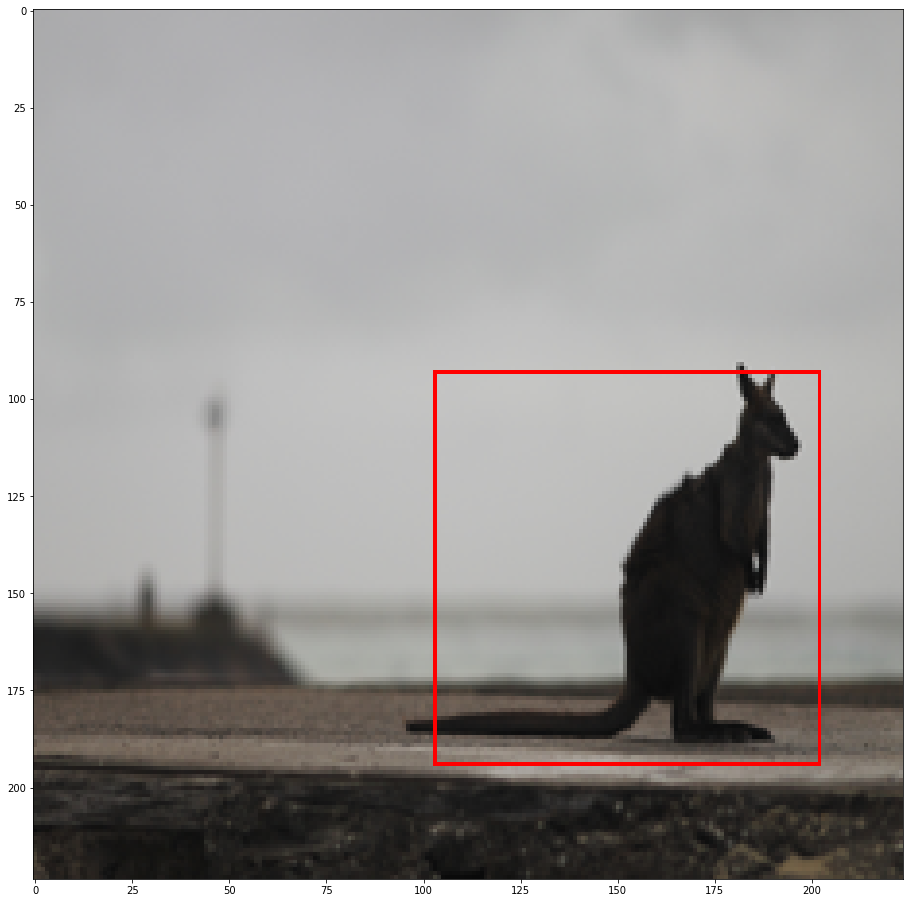

In [30]:
from matplotlib import pyplot as plt
from PIL import *
fig, axs = plt.subplots(1, 1, figsize=(32, 16))
threshold = 0.5
sample = img[1].numpy()
res_img = Image.fromarray((255*sample).astype(np.uint8).transpose(1, 2, 0))
print(res_img)
axs.imshow(res_img)
boxes = output[1]['boxes']
scores = output[1]['scores']
boxes = boxes[scores > threshold].detach().numpy()
print(boxes)
res_img_1 = ImageDraw.Draw(res_img)
for box in boxes:
  res_img_1.rectangle([box[0], box[1], box[2], box[3]],outline = "Red",width = 1)
axs.imshow(res_img)

In [ ]:
res_img = Image.fromarray((255*sample).astype(np.uint8).transpose(1, 2, 0))